## Goal of the Competition
The goal of this competition is to predict if a person has any of three medical conditions. You are being asked to predict if the person has one or more of any of the three medical conditions (Class 1), or none of the three medical conditions (Class 0). You will create a model trained on measurements of health characteristics.

To determine if someone has these medical conditions requires a long and intrusive process to collect information from patients. With predictive models, we can shorten this process and keep patient details private by collecting key characteristics relative to the conditions, then encoding these characteristics.

Your work will help researchers discover the relationship between measurements of certain characteristics and potential patient conditions.

## Dataset Description
The competition data comprises over fifty anonymized health characteristics linked to three age-related conditions. Your goal is to predict whether a subject has or has not been diagnosed with one of these conditions -- a binary classification problem.

Note that this is a Code Competition, in which the actual test set is hidden. In this version, we give some sample data in the correct format to help you author your solutions. When your submission is scored, this example test data will be replaced with the full test set. There are about 400 rows in the full test set.

### Files and Field Descriptions
**train.csv** - The training set.
- `Id` Unique identifier for each observation.
- `AB`-`GL` Fifty-six anonymized health characteristics. All are numeric except for `EJ`, which is categorical.
- `Class` A binary target: `1` indicates the subject has been diagnosed with one of the three conditions, `0` indicates they have not.

**test.csv** - The test set. Your goal is to predict the probability that a subject in this set belongs to each of the two classes.

**greeks.csv** - Supplemental metadata, only available for the training set.
- `Alpha` Identifies the type of age-related condition, if present.
- `A` No age-related condition. Corresponds to class `0`.
- `B`, `D`, `G` The three age-related conditions. Correspond to class `1`.
- `Beta`, `Gamma`, `Delta` Three experimental characteristics.
- `Epsilon` The date the data for this subject was collected. Note that all of the data in the test set was collected after the training set was collected.

**sample_submission.csv** - A sample submission file in the correct format. See the Evaluation page for more details.

### Import libs

In [4]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, KNNImputer
from sklearn.preprocessing import LabelEncoder, StandardScaler, PowerTransformer, QuantileTransformer
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA
from paretochart import pareto

# Personal library
from BMDataAnalysis import plot_distributions, boxplot_grid, scatterplot_high_corr

# Plotting settings
sns.set_style("darkgrid")
sns.set_context("paper")

# Random seeds for reproducibility
random_state = 42
np.random.seed(random_state)
random.seed(random_state)


### Functions definitions

In [5]:
def pie_label(pct, data):
    '''
    Adds the absolute value to the pie chart
    '''
    absolute = round((pct / 100) * len(data))
    return f"{pct:.1f}%\n({absolute})"

## Data Understanding

In [6]:
test = pd.read_csv('../../Data/Raw/test.csv')
train = pd.read_csv('../../Data/Raw/train.csv')
greeks = pd.read_csv('../../Data/Raw/greeks.csv')

train.columns = train.columns.str.strip()
test.columns = test.columns.str.strip()

In [7]:
# Visualize data sets
print('*' * 30, 'TEST DATA SET SAMPLE', '*' * 30)
display(test)
print('*' * 30, 'TRAIN DATA SET', '*' * 30)
display(train.head())
print(train.shape)
print('*' * 30, 'GREEKS DATA SET', '*' * 30)
display(greeks.head())
print(greeks.shape)

****************************** TEST DATA SET SAMPLE ******************************


Id   AB   AF   AH   AM   AR   AX   AY   AZ   BC  ...   FI   FL  \
0  00eed32682bb  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
1  010ebe33f668  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
2  02fa521e1838  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
3  040e15f562a2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
4  046e85c7cc7f  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   

    FR   FS   GB   GE   GF   GH   GI   GL  
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
4  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

[5 rows x 57 columns]

****************************** TRAIN DATA SET ******************************


Id        AB          AF          AH         AM        AR  \
0  000ff2bfdfe9  0.209377  3109.03329   85.200147  22.394407  8.138688   
1  007255e47698  0.145282   978.76416   85.200147  36.968889  8.138688   
2  013f2bd269f5  0.470030  2635.10654   85.200147  32.360553  8.138688   
3  043ac50845d5  0.252107  3819.65177  120.201618  77.112203  8.138688   
4  044fb8a146ec  0.380297  3733.04844   85.200147  14.103738  8.138688   

         AX        AY         AZ          BC  ...        FL        FR  \
0  0.699861  0.025578   9.812214    5.555634  ...  7.298162   1.73855   
1  3.632190  0.025578  13.517790    1.229900  ...  0.173229   0.49706   
2  6.732840  0.025578  12.824570    1.229900  ...  7.709560   0.97556   
3  3.685344  0.025578  11.053708    1.229900  ...  6.122162   0.49706   
4  3.942255  0.054810   3.396778  102.151980  ...  8.153058  48.50134   

         FS         GB          GE            GF         GH         GI  \
0  0.094822  11.339138   72.611063   2003.810319  22.136229  69.834944   
1  0.568932   9.292698   72.611063  27981.562750  29.135430  32.131996   
2  1.198821  37.077772   88.609437  13676.957810  28.022851  35.192676   
3  0.284466  18.529584   82.416803   2094.262452  39.948656  90.493248   
4  0.121914  16.408728  146.109943   8524.370502  45.381316  36.262628   

          GL  Class  
0   0.120343      1  
1  21.978000      0  
2   0.196941      0  
3   0.155829      0  
4   0.096614      1  

[5 rows x 58 columns]

(617, 58)
****************************** GREEKS DATA SET ******************************


Id Alpha Beta Gamma Delta    Epsilon
0  000ff2bfdfe9     B    C     G     D  3/19/2019
1  007255e47698     A    C     M     B    Unknown
2  013f2bd269f5     A    C     M     B    Unknown
3  043ac50845d5     A    C     M     B    Unknown
4  044fb8a146ec     D    B     F     B  3/25/2020

(617, 6)


### Data Visualization

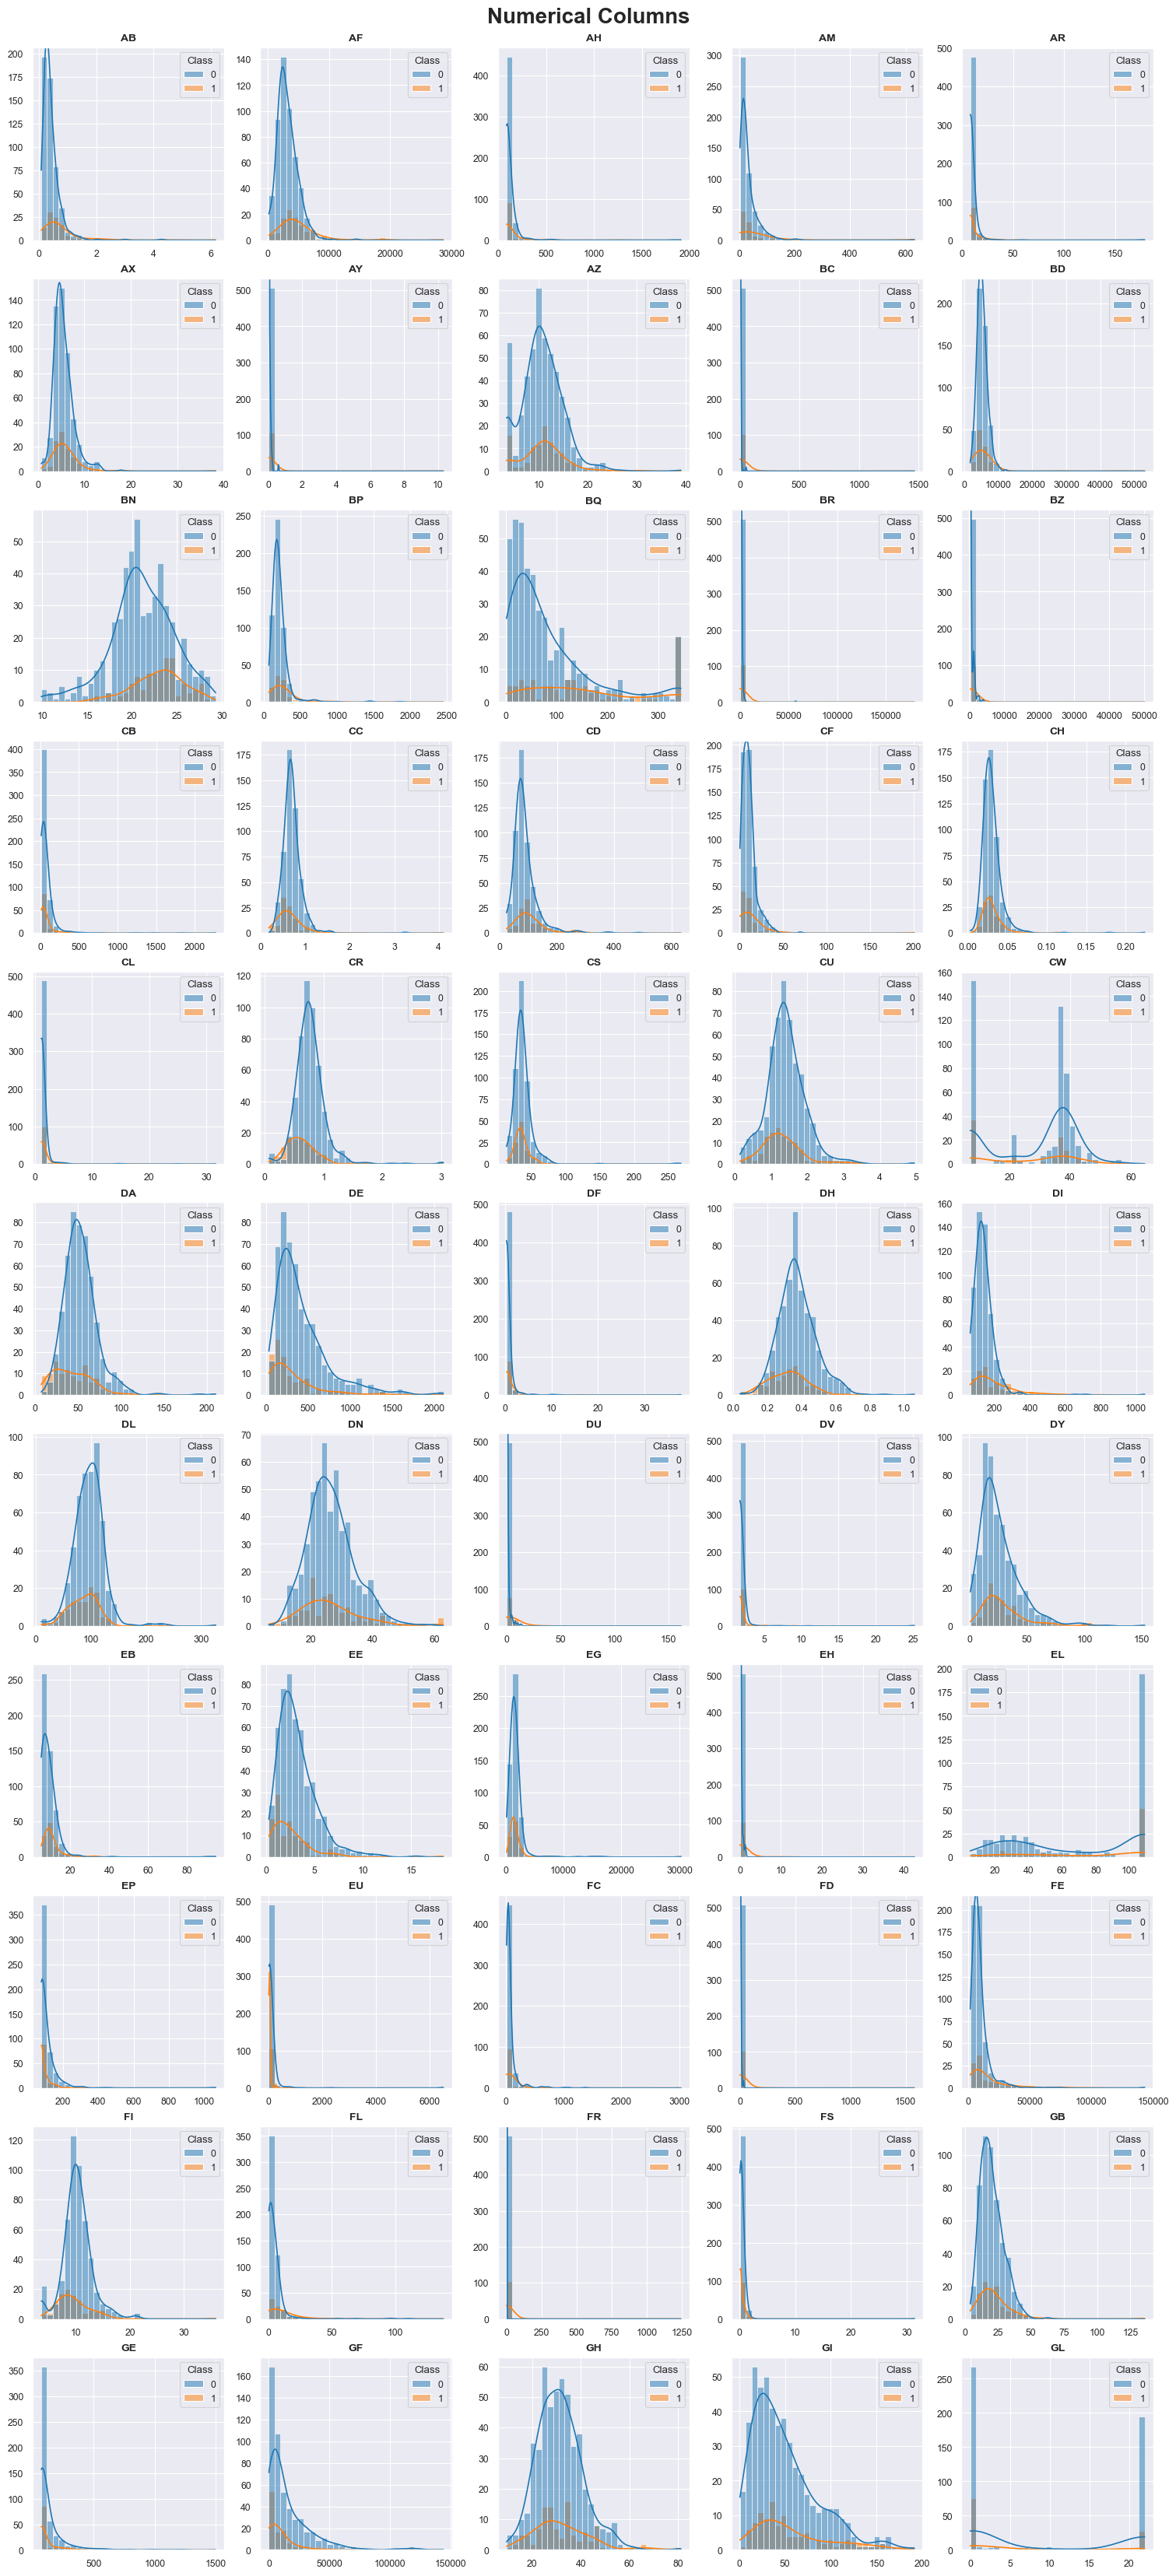

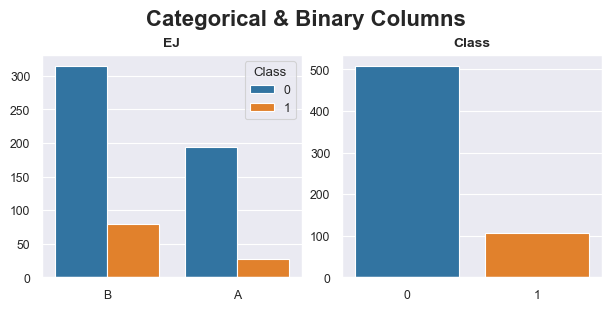

In [8]:
# Visualize distributions
plot_distributions(train.drop(columns='Id'), hue='Class')

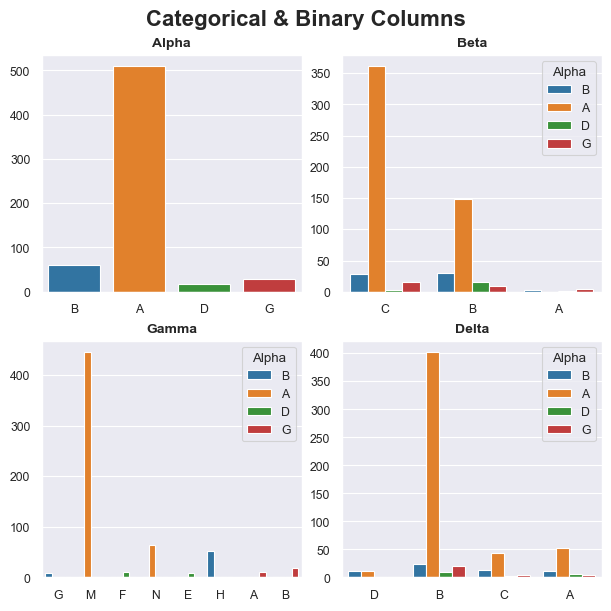

In [9]:
plot_distributions(greeks.drop(columns=['Id', 'Epsilon']), hue='Alpha')

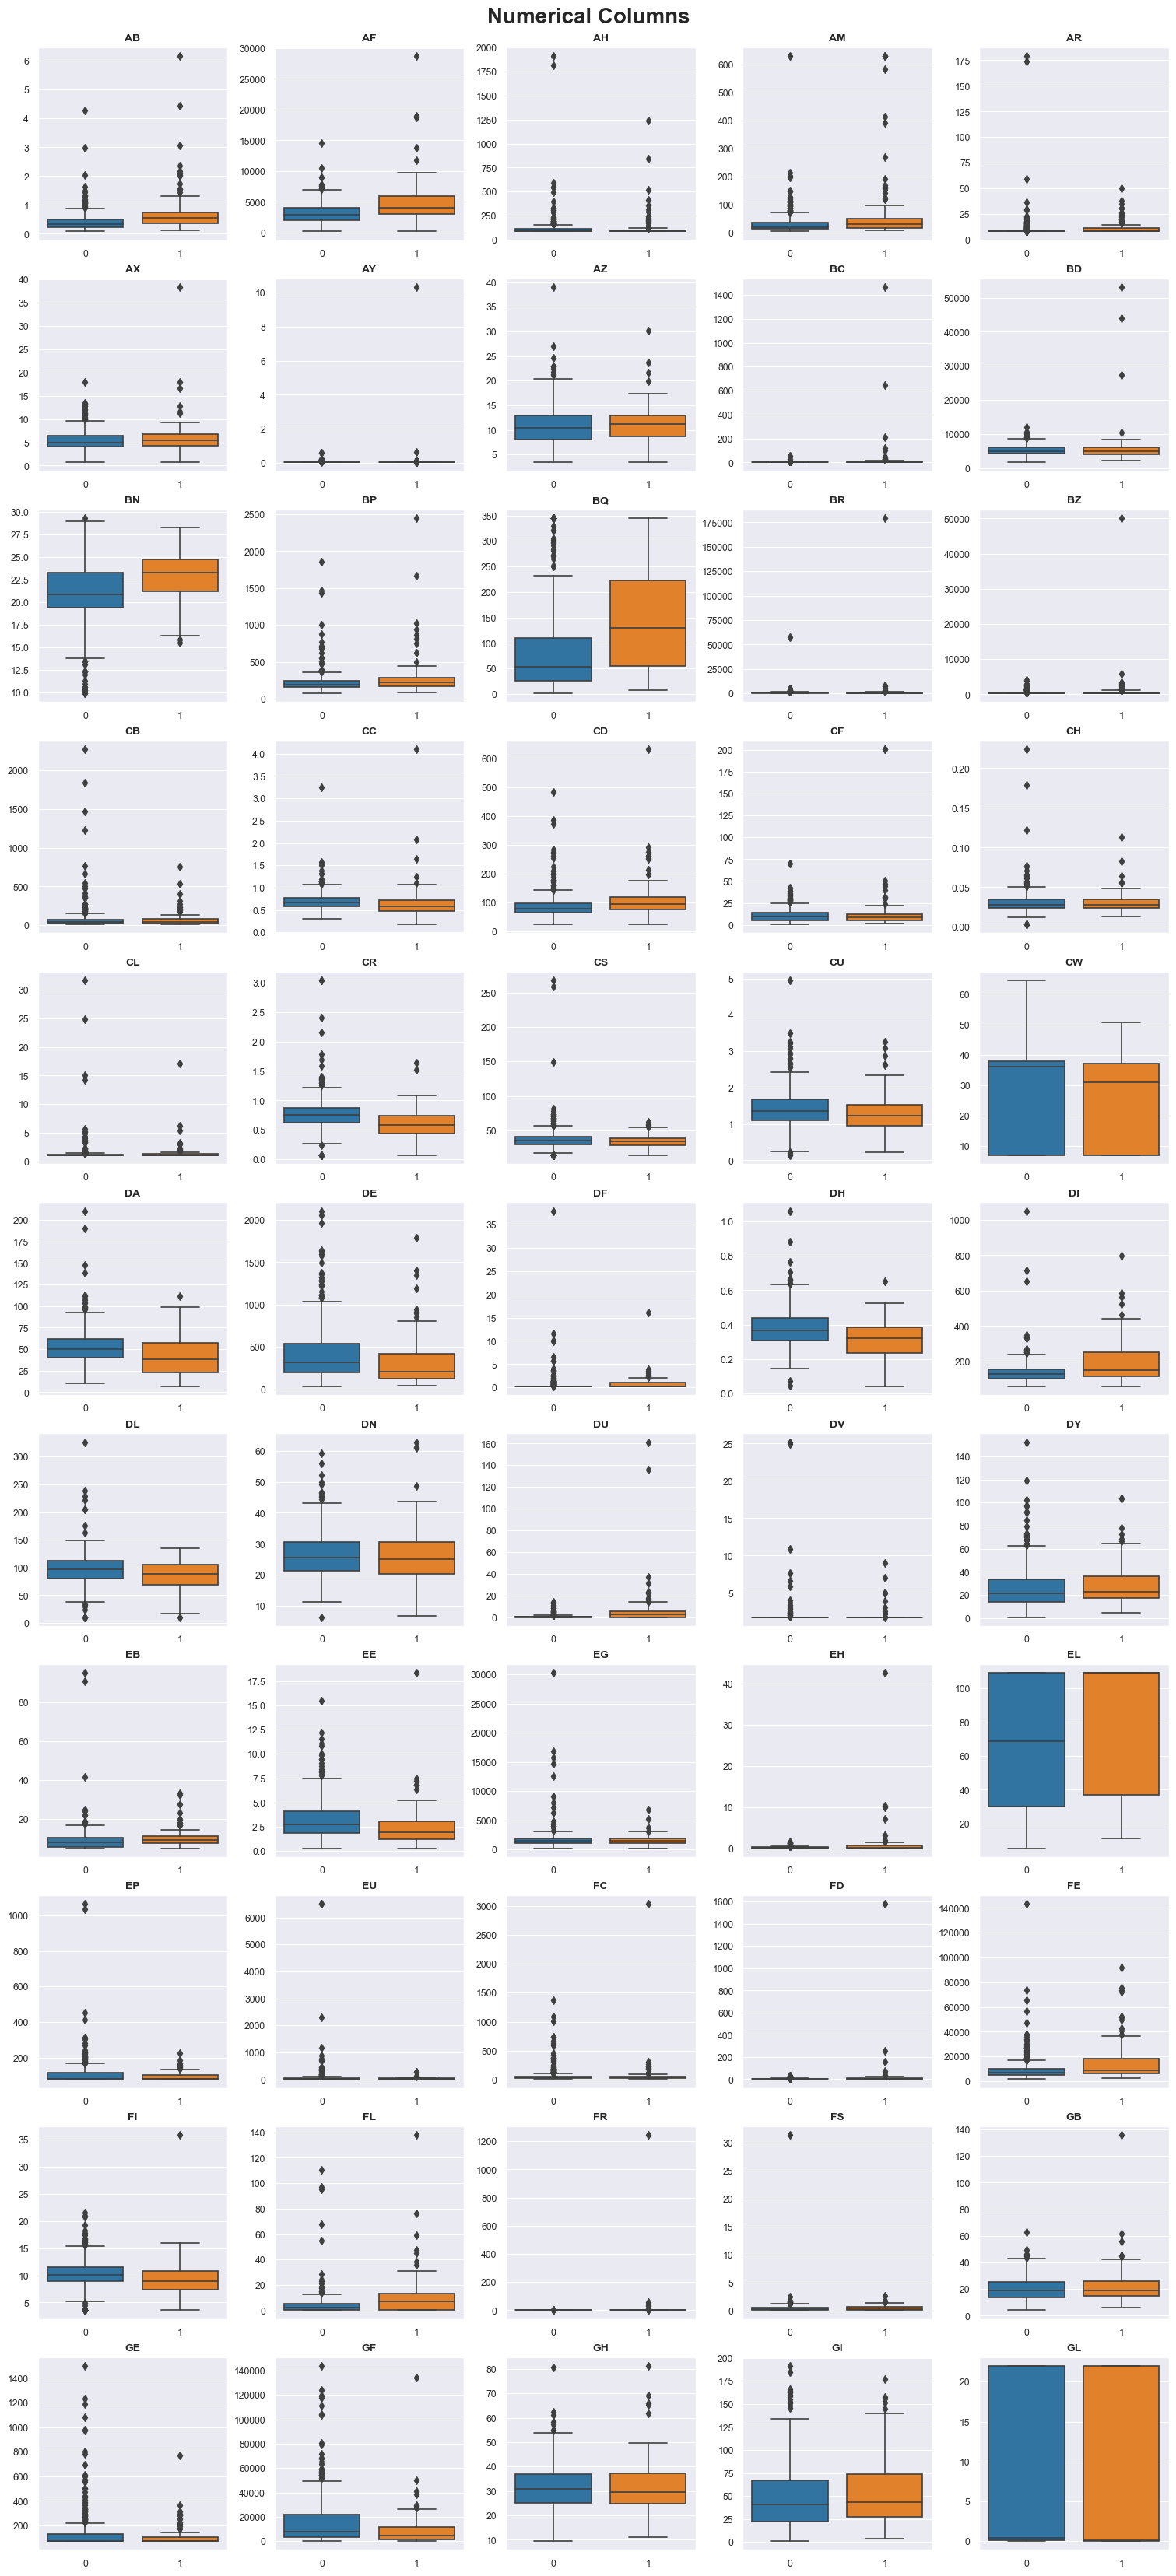

In [10]:
# Visualize Outliers
boxplot_grid(train, hue='Class')

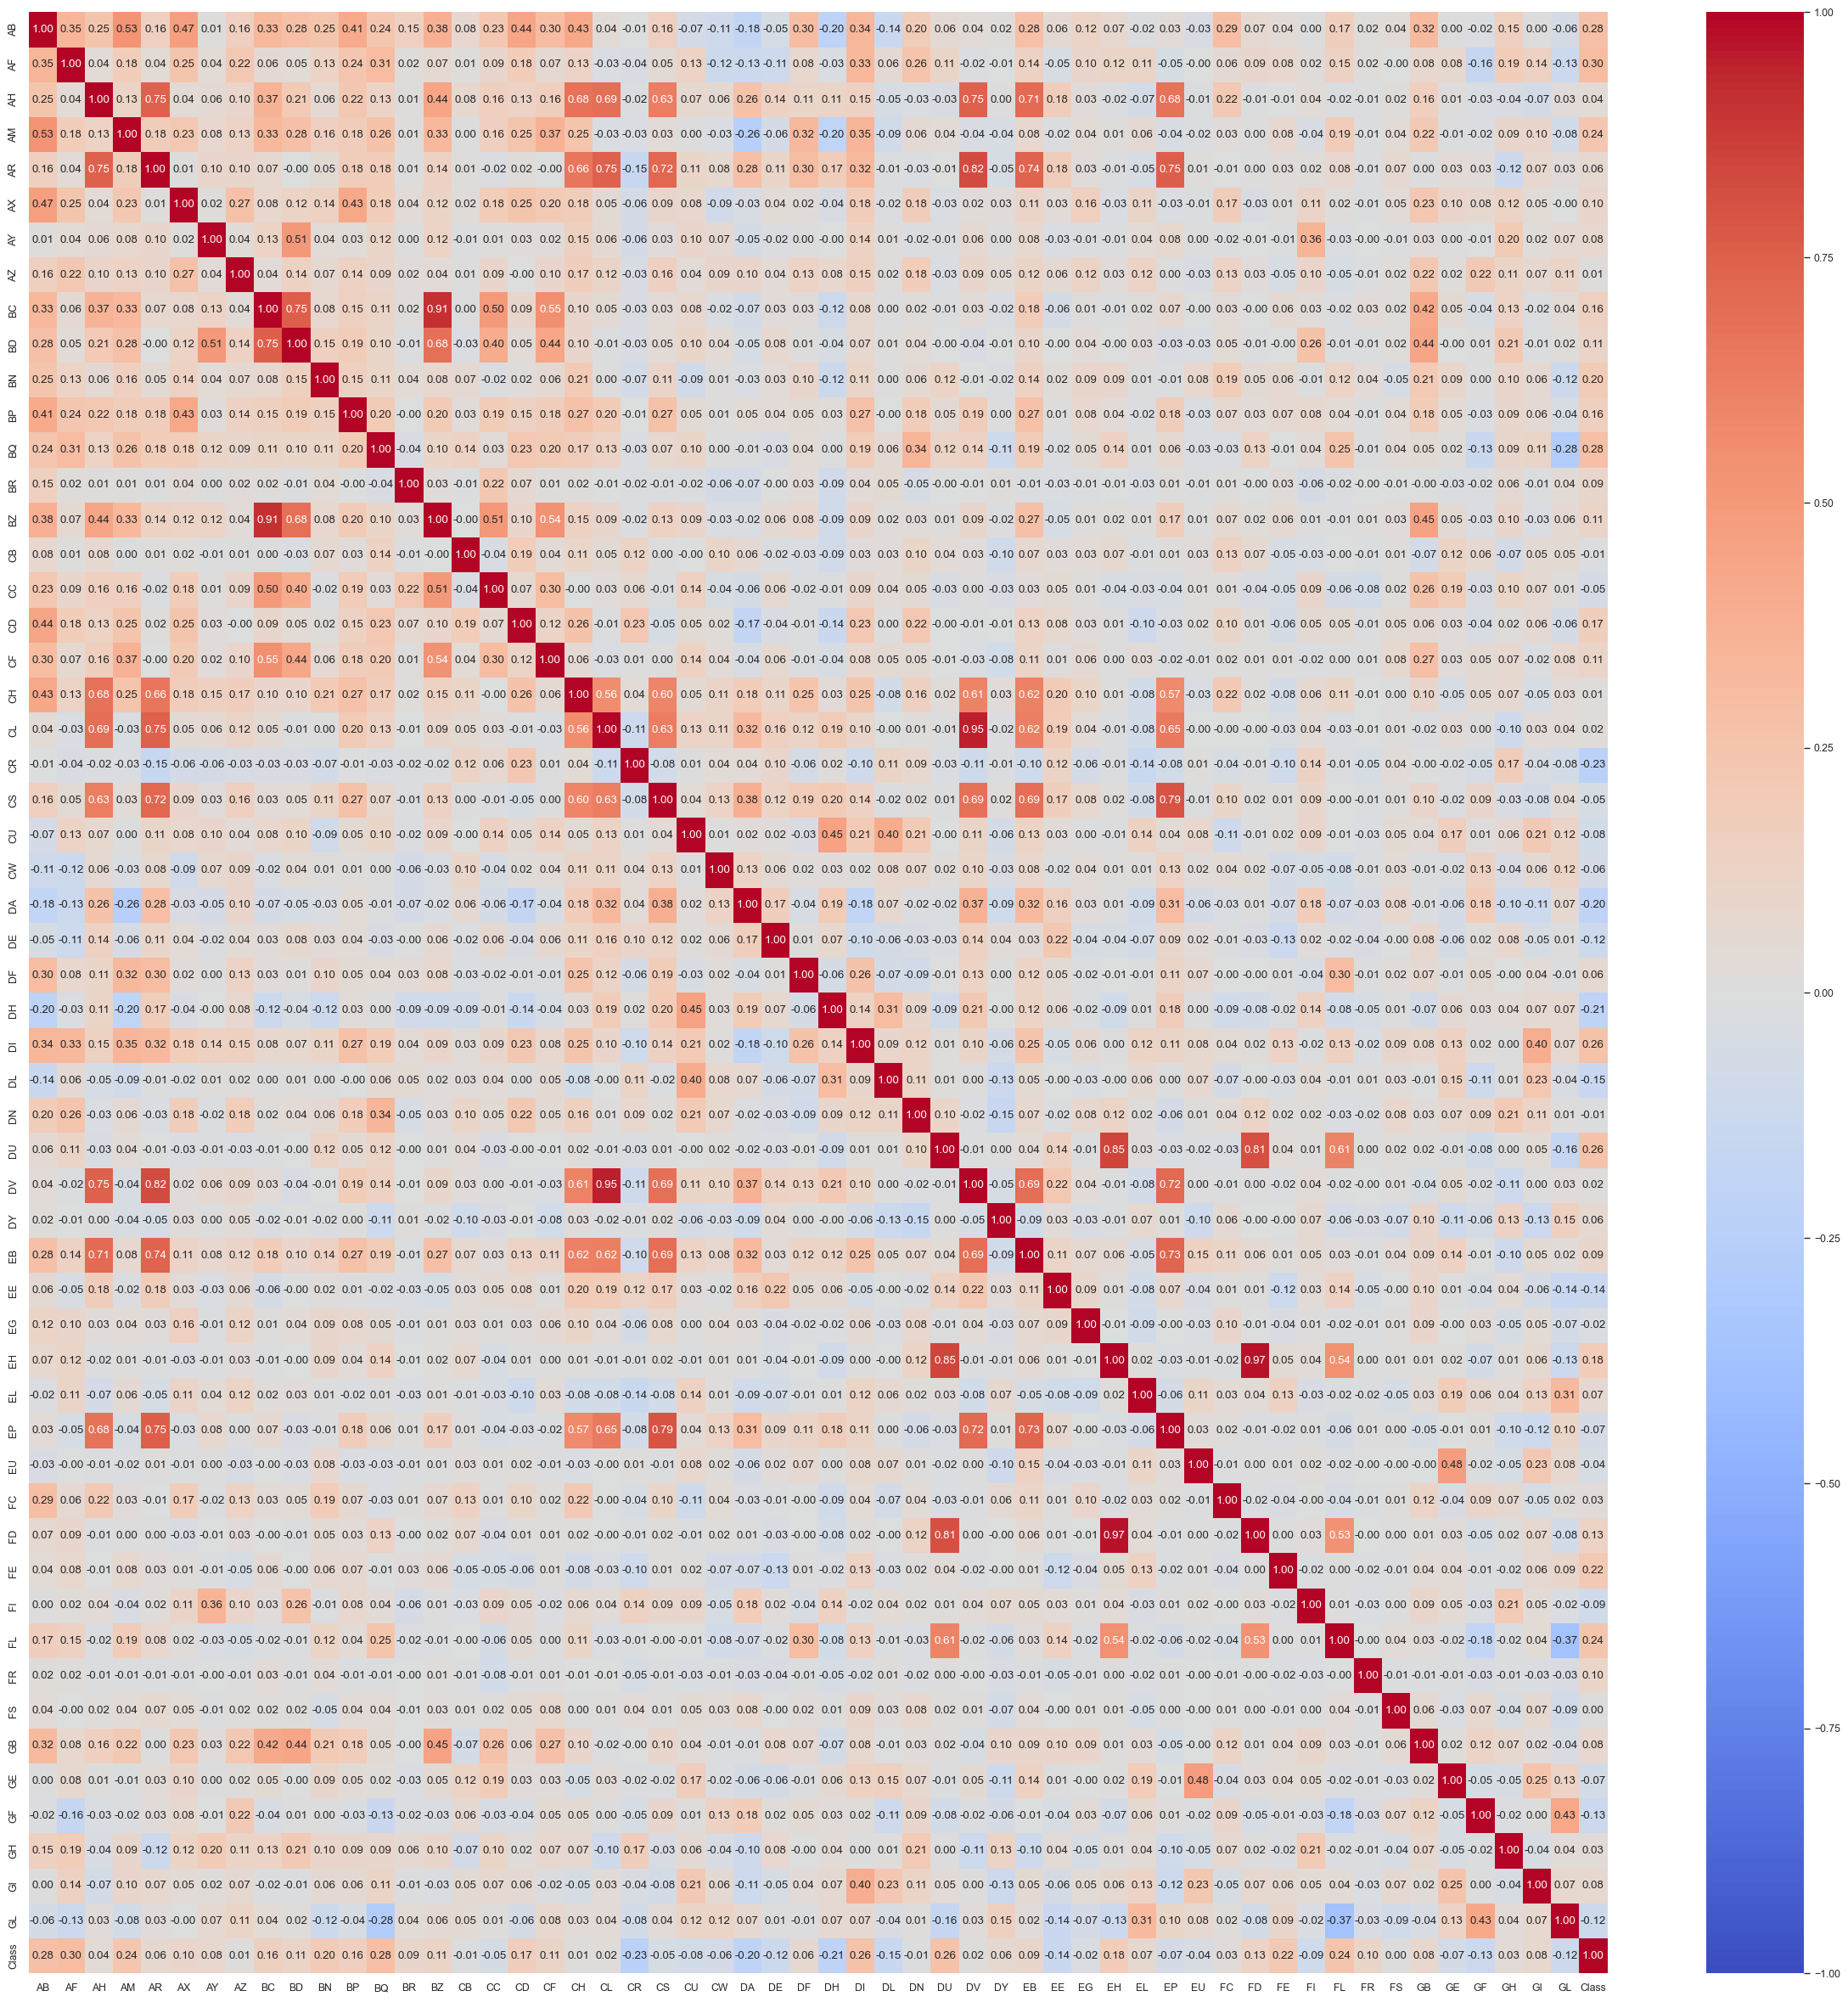

In [11]:
# Visualize correlations
plt.figure(figsize=(30, 30))
sns.heatmap(train.corr(numeric_only=True), annot=True, fmt='.2f', vmin=-1, vmax=1, cmap='coolwarm');

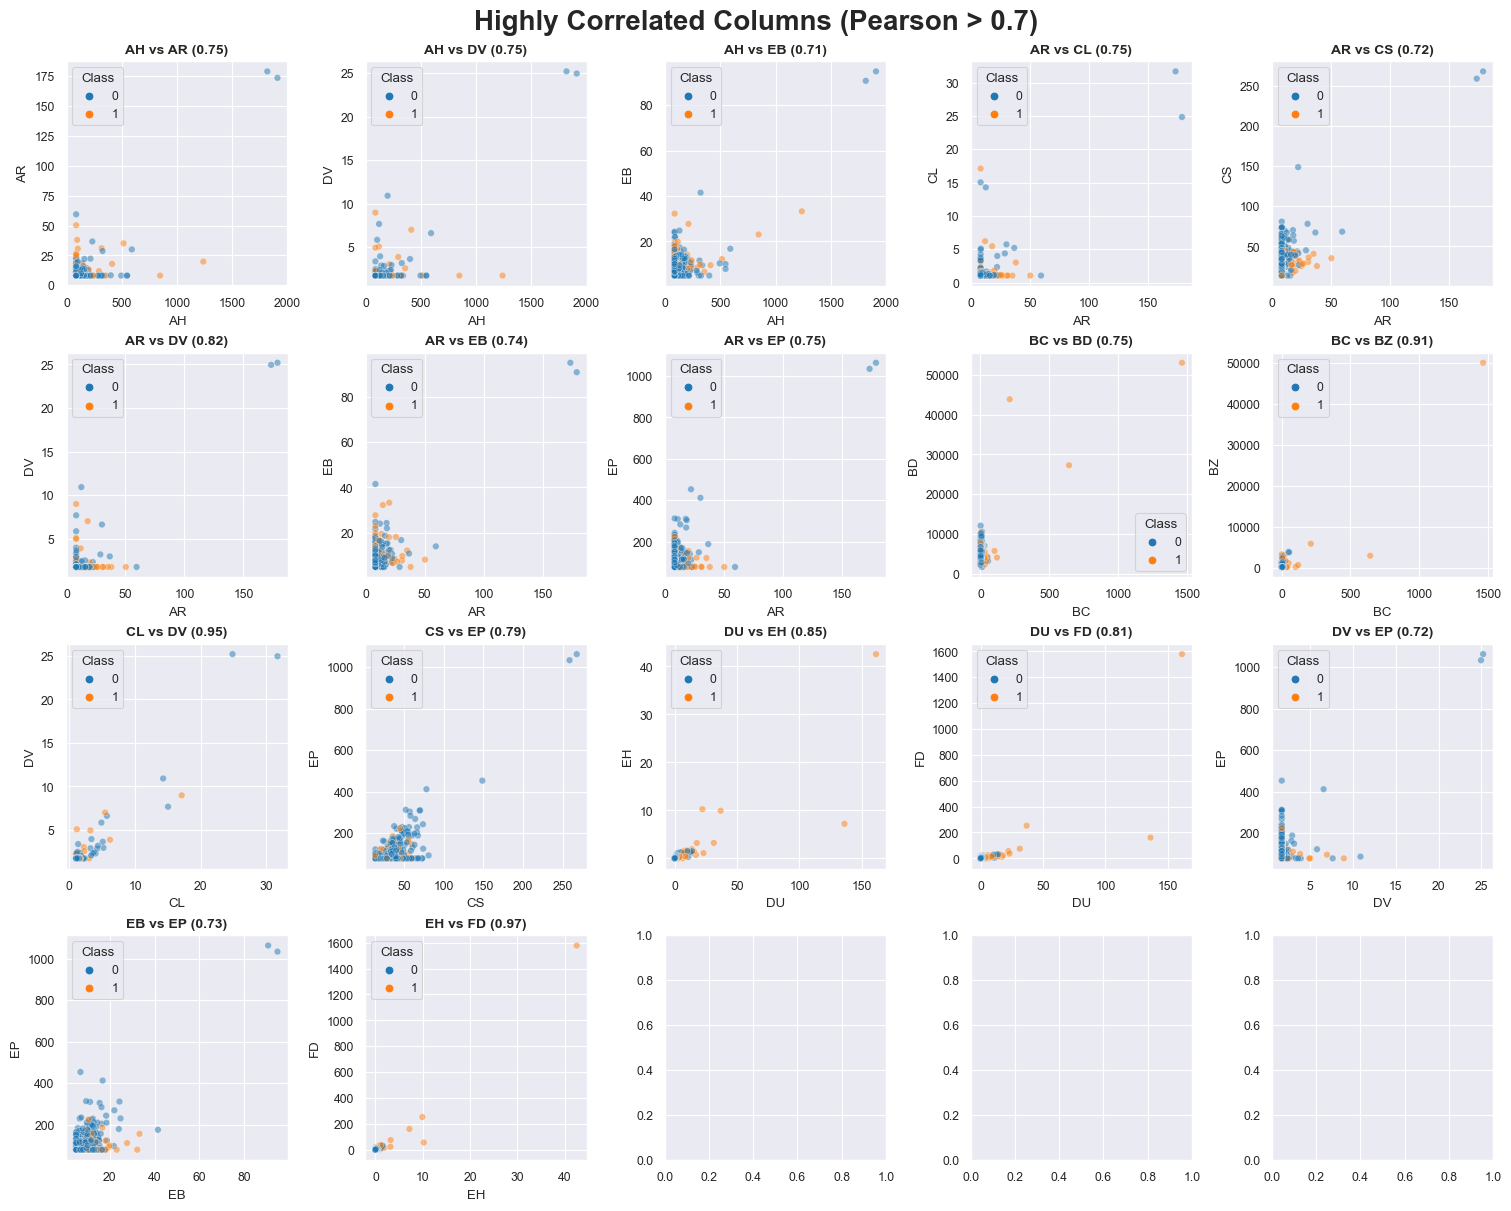

In [12]:
scatterplot_high_corr(train.drop(columns='Id'), threshold=0.7, hue='Class', alpha=0.5)

Pearson: 0.7409995605603888


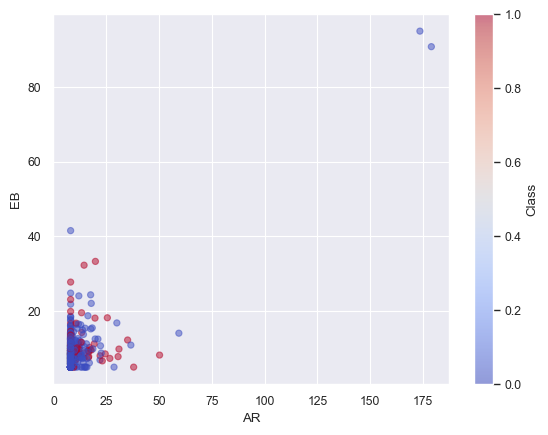

In [13]:
train.plot.scatter(x='AR', y='EB', c='Class', colormap='coolwarm', alpha=0.5)
print('Pearson:', train['AR'].corr(train['EB']))

Pearson: 0.1671706528744289


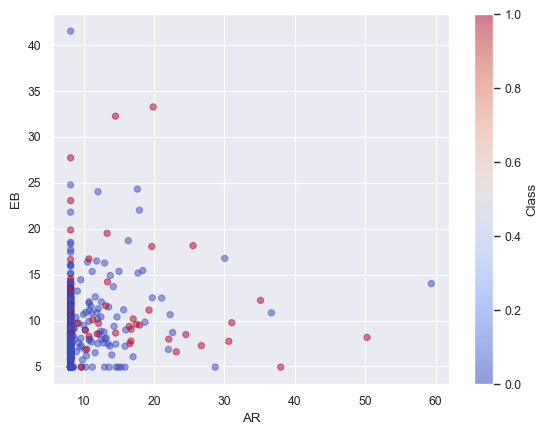

In [14]:
t = train[['AR', 'EB', 'Class']][train['AR'] < 150]
t.plot.scatter(x='AR', y='EB', c='Class', colormap='coolwarm', alpha=0.5)
print('Pearson:', t['AR'].corr(t['EB']))

## Data Preparation

### Missing Values and Duplicates

In [15]:
# Check for missing values
print('*' * 30, 'MISSING VALUES', '*' * 30, end='\n\n')
test_missing = round((test.isnull().sum() / len(test)) * 100, 2)
print('Test data set missing percentage: ', test_missing[test_missing > 0], sep='\n', end='\n\n')

train_missing = round((train.isnull().sum() / len(train)) * 100, 2)
print('Train data set missing percentage: ', train_missing[train_missing > 0], sep='\n', end='\n\n')

greeks_missing = round((greeks.isnull().sum() / len(greeks)) * 100, 2)
print('Greeks data set missing percentage: ', greeks_missing[greeks_missing > 0], sep='\n', end='\n\n')

# Check for duplicates
print('*' * 30, 'DUPLICATES', '*' * 30, end='\n\n')
print('Test data set: ', test.duplicated().sum())
print('Train data set: ', train.duplicated().sum())
print('Greeks data set: ', greeks.duplicated().sum())

****************************** MISSING VALUES ******************************

Test data set missing percentage: 
Series([], dtype: float64)

Train data set missing percentage: 
BQ    9.72
CB    0.32
CC    0.49
DU    0.16
EL    9.72
FC    0.16
FL    0.16
FS    0.32
GL    0.16
dtype: float64

Greeks data set missing percentage: 
Series([], dtype: float64)

****************************** DUPLICATES ******************************

Test data set:  0
Train data set:  0
Greeks data set:  0


In [16]:
# Result of dropping rows with missing values
train_drop_rows = train.dropna()
print('Train data set shape after dropping rows with missing values:', train_drop_rows.shape)
print('Number of rows dropped:', train.shape[0] - train_drop_rows.shape[0], 
      f'({round(((train.shape[0] - train_drop_rows.shape[0]) / train.shape[0]) * 100, 2)}% of the original data set)', end='\n\n')

# Result of dropping colums with missing values
train_drop_cols = train.dropna(axis=1)
print('Train data set shape after dropping columns with missing values:', train_drop_cols.shape)
print('Number of columns dropped:', train.shape[1] - train_drop_cols.shape[1],
      f'({((train.shape[1] - train_drop_cols.shape[1]) / train.shape[1]) * 100 :.2f}% of the original data set)', end='\n\n')

Train data set shape after dropping rows with missing values: (548, 58)
Number of rows dropped: 69 (11.18% of the original data set)

Train data set shape after dropping columns with missing values: (617, 49)
Number of columns dropped: 9 (15.52% of the original data set)



In [17]:
# Remove rows with less than 1% missing values
missing_cols = train_missing[train_missing > 0].index.tolist()
missing_cols.append('Class')
missing_cols.remove('BQ')
missing_cols.remove('EL')
train[missing_cols][train[missing_cols].isnull().any(axis=1)]

CB        CC        DU          FC         FL        FS  \
24          NaN       NaN  0.005518  117.815712   0.173229  0.433472   
114         NaN       NaN  0.005518   22.379616   0.173229  0.067730   
330  536.221322       NaN  0.005518         NaN   0.173229       NaN   
562   15.165150  0.899028  0.558657   54.429648  95.038650       NaN   
594   27.609764  0.761854       NaN   32.187120        NaN  0.731484   

            GL  Class  
24   21.978000      0  
114  21.978000      0  
330  21.978000      1  
562   0.007333      0  
594        NaN      0

In [18]:
# Get indexes of rows with missing values and drop them from train and greeks data sets
idx_missing = train[missing_cols][train[missing_cols].isnull().any(axis=1)].index
train = train.drop(idx_missing, axis=0).reset_index(drop=True)
greeks = greeks.drop(idx_missing, axis=0).reset_index(drop=True)
print(train.shape)
print(greeks.shape)

(612, 58)
(612, 6)


#### KNN Imputer

In [19]:
knn = KNNImputer(n_neighbors=5)
knn_imp = pd.DataFrame(knn.fit_transform(train.drop(columns=['Id', 'EJ'])), columns=knn.feature_names_in_)
knn_imp

AB          AF          AH          AM         AR        AX  \
0    0.209377  3109.03329   85.200147   22.394407   8.138688  0.699861   
1    0.145282   978.76416   85.200147   36.968889   8.138688  3.632190   
2    0.470030  2635.10654   85.200147   32.360553   8.138688  6.732840   
3    0.252107  3819.65177  120.201618   77.112203   8.138688  3.685344   
4    0.380297  3733.04844   85.200147   14.103738   8.138688  3.942255   
..        ...         ...         ...         ...        ...       ...   
607  0.149555  3130.05946  123.763599    9.513984  13.020852  3.499305   
608  0.435846  5462.03438   85.200147   46.551007  15.973224  5.979825   
609  0.427300  2459.10720  130.138587   55.355778  10.005552  8.070549   
610  0.363205  1263.53524   85.200147   23.685856   8.138688  7.981959   
611  0.482849  2672.53426  546.663930  112.006102   8.138688  3.198099   

           AY         AZ          BC          BD  ...         FL        FR  \
0    0.025578   9.812214    5.555634  4126.58731  ...   7.298162   1.73855   
1    0.025578  13.517790    1.229900  5496.92824  ...   0.173229   0.49706   
2    0.025578  12.824570    1.229900  5135.78024  ...   7.709560   0.97556   
3    0.025578  11.053708    1.229900  4169.67738  ...   6.122162   0.49706   
4    0.054810   3.396778  102.151980  5728.73412  ...   8.153058  48.50134   
..        ...        ...         ...         ...  ...        ...       ...   
607  0.077343   8.545512    2.804172  4157.68439  ...   0.173229   1.26092   
608  0.025882  12.622906    3.777550  5654.07556  ...  10.223150   1.24236   
609  0.025578  15.408390    1.229900  5888.87769  ...   0.173229   0.49706   
610  0.025578   7.524588    1.229900  4517.86560  ...   9.256996   0.78764   
611  0.116928   3.396778    7.948668  2818.01707  ...   0.173229   1.14492   

           FS         GB          GE            GF         GH          GI  \
0    0.094822  11.339138   72.611063   2003.810319  22.136229   69.834944   
1    0.568932   9.292698   72.611063  27981.562750  29.135430   32.131996   
2    1.198821  37.077772   88.609437  13676.957810  28.022851   35.192676   
3    0.284466  18.529584   82.416803   2094.262452  39.948656   90.493248   
4    0.121914  16.408728  146.109943   8524.370502  45.381316   36.262628   
..        ...        ...         ...           ...        ...         ...   
607  0.067730   8.967128  217.148554   8095.932828  24.640462   69.191944   
608  0.426699  35.896418  496.994214   3085.308063  29.648928  124.808872   
609  0.067730  19.962092  128.896894   6474.652866  26.166072  119.559420   
610  0.670527  24.594488   72.611063   1965.343176  25.116750   37.155112   
611  0.149006  13.673940   72.611063   6850.484442  45.745974  114.842372   

            GL  Class  
0     0.120343    1.0  
1    21.978000    0.0  
2     0.196941    0.0  
3     0.155829    0.0  
4     0.096614    1.0  
..         ...    ...  
607  21.978000    0.0  
608   0.145340    0.0  
609  21.978000    0.0  
610   0.184622    0.0  
611  21.978000    0.0  

[612 rows x 56 columns]

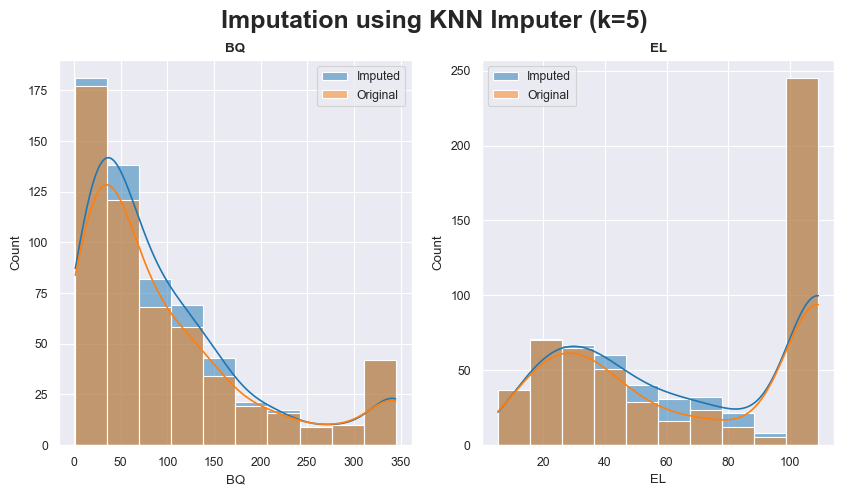

In [20]:
# Plot distributions of imputed and original values
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('Imputation using KNN Imputer (k=5)', fontweight='bold', fontsize=18)

sns.histplot(knn_imp['BQ'], bins=10, alpha=0.5, label='Imputed', kde=True, ax=axs[0])
sns.histplot(train['BQ'], bins=10, alpha=0.5, label='Original', kde=True, ax=axs[0])
axs[0].set_title('BQ', fontweight='bold')
axs[0].legend()

sns.histplot(knn_imp['EL'], bins=10, alpha=0.5, label='Imputed', kde=True, ax=axs[1])
sns.histplot(train['EL'], bins=10, alpha=0.5, label='Original', kde=True, ax=axs[1])
axs[1].set_title('EL', fontweight='bold')
axs[1].legend();

#### Iterative Imputer

In [21]:
ii = IterativeImputer(max_iter=100, random_state=random_state)
ii_imp = pd.DataFrame(ii.fit_transform(train.drop(columns=['Id', 'EJ'])), columns=ii.feature_names_in_)
ii_imp

AB          AF          AH          AM         AR        AX  \
0    0.209377  3109.03329   85.200147   22.394407   8.138688  0.699861   
1    0.145282   978.76416   85.200147   36.968889   8.138688  3.632190   
2    0.470030  2635.10654   85.200147   32.360553   8.138688  6.732840   
3    0.252107  3819.65177  120.201618   77.112203   8.138688  3.685344   
4    0.380297  3733.04844   85.200147   14.103738   8.138688  3.942255   
..        ...         ...         ...         ...        ...       ...   
607  0.149555  3130.05946  123.763599    9.513984  13.020852  3.499305   
608  0.435846  5462.03438   85.200147   46.551007  15.973224  5.979825   
609  0.427300  2459.10720  130.138587   55.355778  10.005552  8.070549   
610  0.363205  1263.53524   85.200147   23.685856   8.138688  7.981959   
611  0.482849  2672.53426  546.663930  112.006102   8.138688  3.198099   

           AY         AZ          BC          BD  ...         FL        FR  \
0    0.025578   9.812214    5.555634  4126.58731  ...   7.298162   1.73855   
1    0.025578  13.517790    1.229900  5496.92824  ...   0.173229   0.49706   
2    0.025578  12.824570    1.229900  5135.78024  ...   7.709560   0.97556   
3    0.025578  11.053708    1.229900  4169.67738  ...   6.122162   0.49706   
4    0.054810   3.396778  102.151980  5728.73412  ...   8.153058  48.50134   
..        ...        ...         ...         ...  ...        ...       ...   
607  0.077343   8.545512    2.804172  4157.68439  ...   0.173229   1.26092   
608  0.025882  12.622906    3.777550  5654.07556  ...  10.223150   1.24236   
609  0.025578  15.408390    1.229900  5888.87769  ...   0.173229   0.49706   
610  0.025578   7.524588    1.229900  4517.86560  ...   9.256996   0.78764   
611  0.116928   3.396778    7.948668  2818.01707  ...   0.173229   1.14492   

           FS         GB          GE            GF         GH          GI  \
0    0.094822  11.339138   72.611063   2003.810319  22.136229   69.834944   
1    0.568932   9.292698   72.611063  27981.562750  29.135430   32.131996   
2    1.198821  37.077772   88.609437  13676.957810  28.022851   35.192676   
3    0.284466  18.529584   82.416803   2094.262452  39.948656   90.493248   
4    0.121914  16.408728  146.109943   8524.370502  45.381316   36.262628   
..        ...        ...         ...           ...        ...         ...   
607  0.067730   8.967128  217.148554   8095.932828  24.640462   69.191944   
608  0.426699  35.896418  496.994214   3085.308063  29.648928  124.808872   
609  0.067730  19.962092  128.896894   6474.652866  26.166072  119.559420   
610  0.670527  24.594488   72.611063   1965.343176  25.116750   37.155112   
611  0.149006  13.673940   72.611063   6850.484442  45.745974  114.842372   

            GL  Class  
0     0.120343    1.0  
1    21.978000    0.0  
2     0.196941    0.0  
3     0.155829    0.0  
4     0.096614    1.0  
..         ...    ...  
607  21.978000    0.0  
608   0.145340    0.0  
609  21.978000    0.0  
610   0.184622    0.0  
611  21.978000    0.0  

[612 rows x 56 columns]

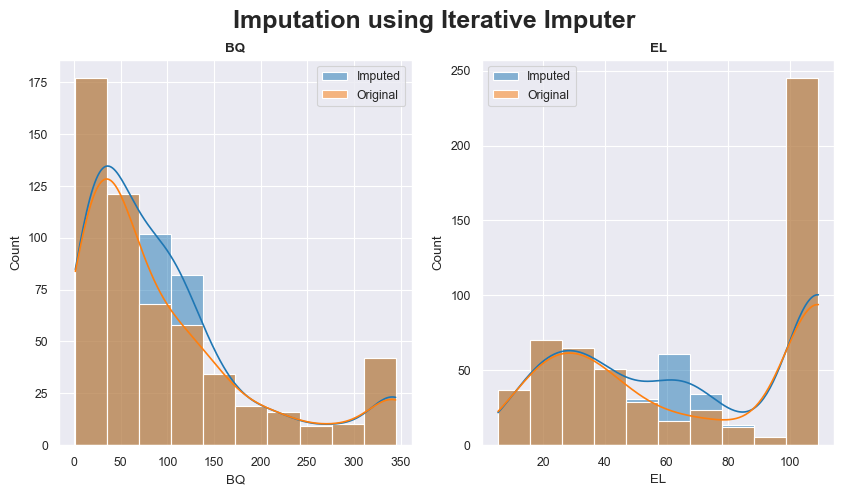

In [22]:
# Plot distributions of imputed and original values
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('Imputation using Iterative Imputer', fontweight='bold', fontsize=18)

sns.histplot(ii_imp['BQ'], bins=10, alpha=0.5, label='Imputed', kde=True, ax=axs[0])
sns.histplot(train['BQ'], bins=10, alpha=0.5, label='Original', kde=True, ax=axs[0])
axs[0].set_title('BQ', fontweight='bold')
axs[0].legend()

sns.histplot(ii_imp['EL'], bins=10, alpha=0.5, label='Imputed', kde=True, ax=axs[1])
sns.histplot(train['EL'], bins=10, alpha=0.5, label='Original', kde=True, ax=axs[1])
axs[1].set_title('EL', fontweight='bold')
axs[1].legend();

### Drop ID Column

In [23]:
train = train.drop(columns='Id')
test = test.drop(columns='Id')
greeks = greeks.drop(columns='Id')

### Split Train and Test data sets

In [24]:
# Define features and target
X = train.drop(columns='Class')
y = train['Class']

# Split data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=random_state, stratify=y)

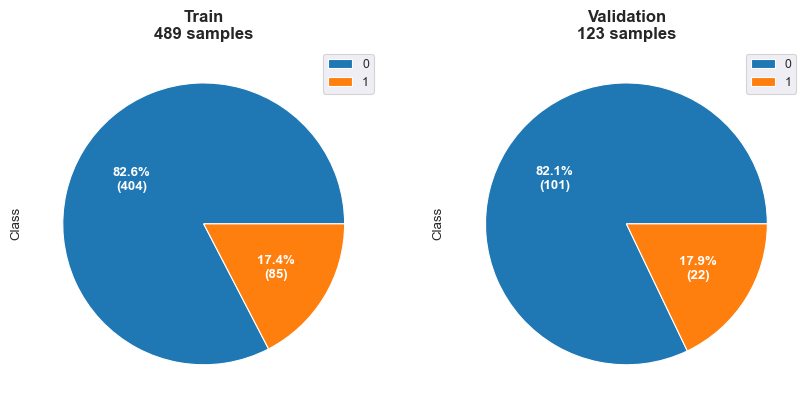

In [25]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Plot train set target distribution
y_train.value_counts().plot.pie(autopct=lambda pct: pie_label(pct, y_train), ax=axs[0], textprops={'color' : "w", 'fontweight' : 'bold'})
axs[0].set_title(f'Train\n{len(y_train)} samples', fontdict={'fontsize' : '12', 'fontweight': 'bold'})
axs[0].legend()

# Plot validation set target distribution
y_val.value_counts().plot.pie(autopct=lambda pct: pie_label(pct, y_val), ax=axs[1], textprops={'color' : "w", 'fontweight' : 'bold'})
axs[1].set_title(f'Validation\n{len(y_val)} samples', fontdict={'fontsize' : '12', 'fontweight': 'bold'})
axs[1].legend();

### Encode Categorical Variable

In [26]:
# Ecoding categorical features
le = LabelEncoder()
X_train['EJ'] = le.fit_transform(X_train['EJ'])
X_val['EJ'] = le.transform(X_val['EJ'])
test['EJ'] = le.transform(test['EJ'])

In [27]:
list(le.classes_)

['A', 'B']

### Impute Missing Variables with KNN Imputer

In [28]:
# Impute missing values using KNN Imputer (k=5)
knn = KNNImputer(n_neighbors=5)
X_train_imp = pd.DataFrame(knn.fit_transform(X_train), columns=knn.feature_names_in_, index=X_train.index)
X_val_imp = pd.DataFrame(knn.transform(X_val), columns=knn.feature_names_in_, index=X_val.index)

# Recheck for missing values
print('Number of missing values in train set:', X_train_imp.isnull().sum().sum())
print('Number of missing values in validation set:', X_val_imp.isnull().sum().sum())

Number of missing values in train set: 0
Number of missing values in validation set: 0


### Handle Outliers

In [29]:
def remove_outliers(X, y, random_state=random_state):
    out = IsolationForest(random_state=random_state)
    out_pred = out.fit_predict(X)
    X = X[out_pred == 1]
    y = y.loc[X.index]
    return X, y

In [30]:
out = IsolationForest(random_state=random_state)
out_pred = out.fit_predict(X_train_imp)
outliers = X_train_imp.copy()
outliers['outlier'] = out_pred
outliers['outlier'] = outliers['outlier'].map({1: 0, -1: 1})
outliers['Class'] = y_train

print('Number of outliers in train set:', outliers['outlier'].sum())

Number of outliers in train set: 10


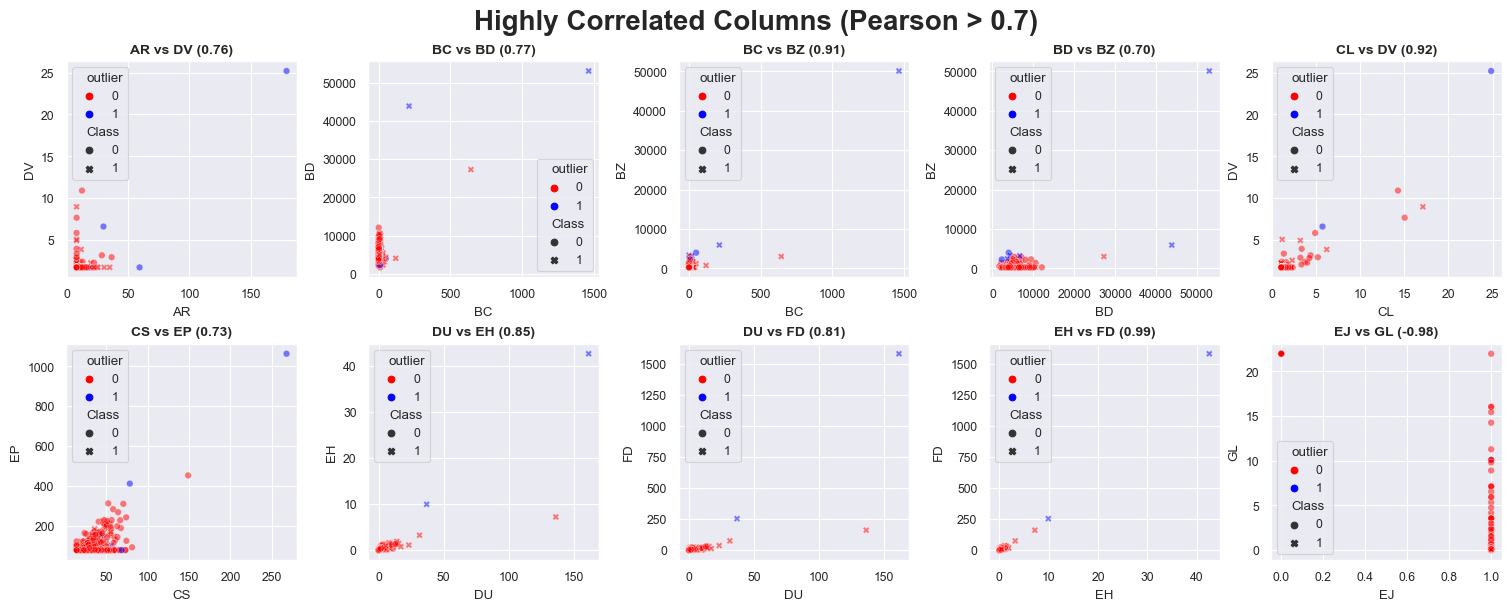

In [31]:
scatterplot_high_corr(outliers, threshold=0.7, hue='outlier', style='Class', alpha=0.5, palette=['r', 'b'], n_cols=5)

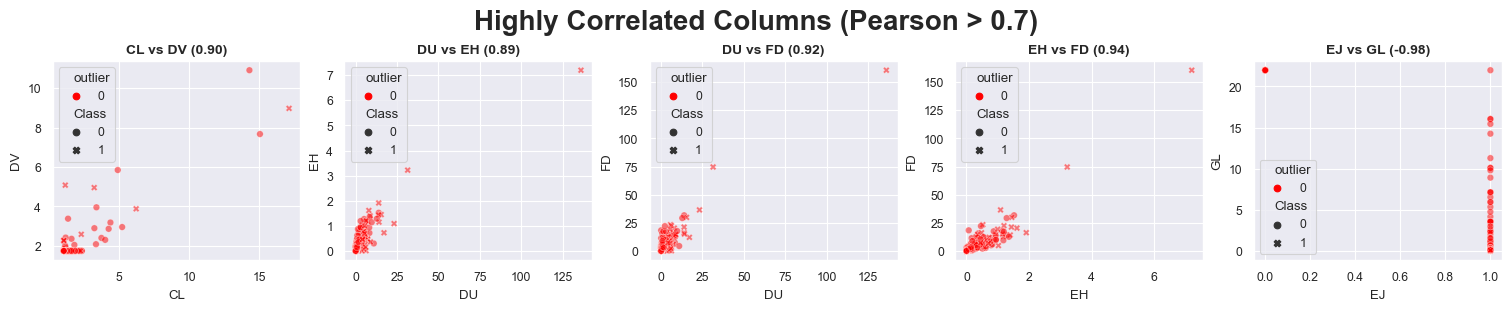

In [32]:
scatterplot_high_corr(outliers[outliers['outlier'] == 0], threshold=0.7, hue='outlier', style='Class', alpha=0.5, palette=['r'], n_cols=5)

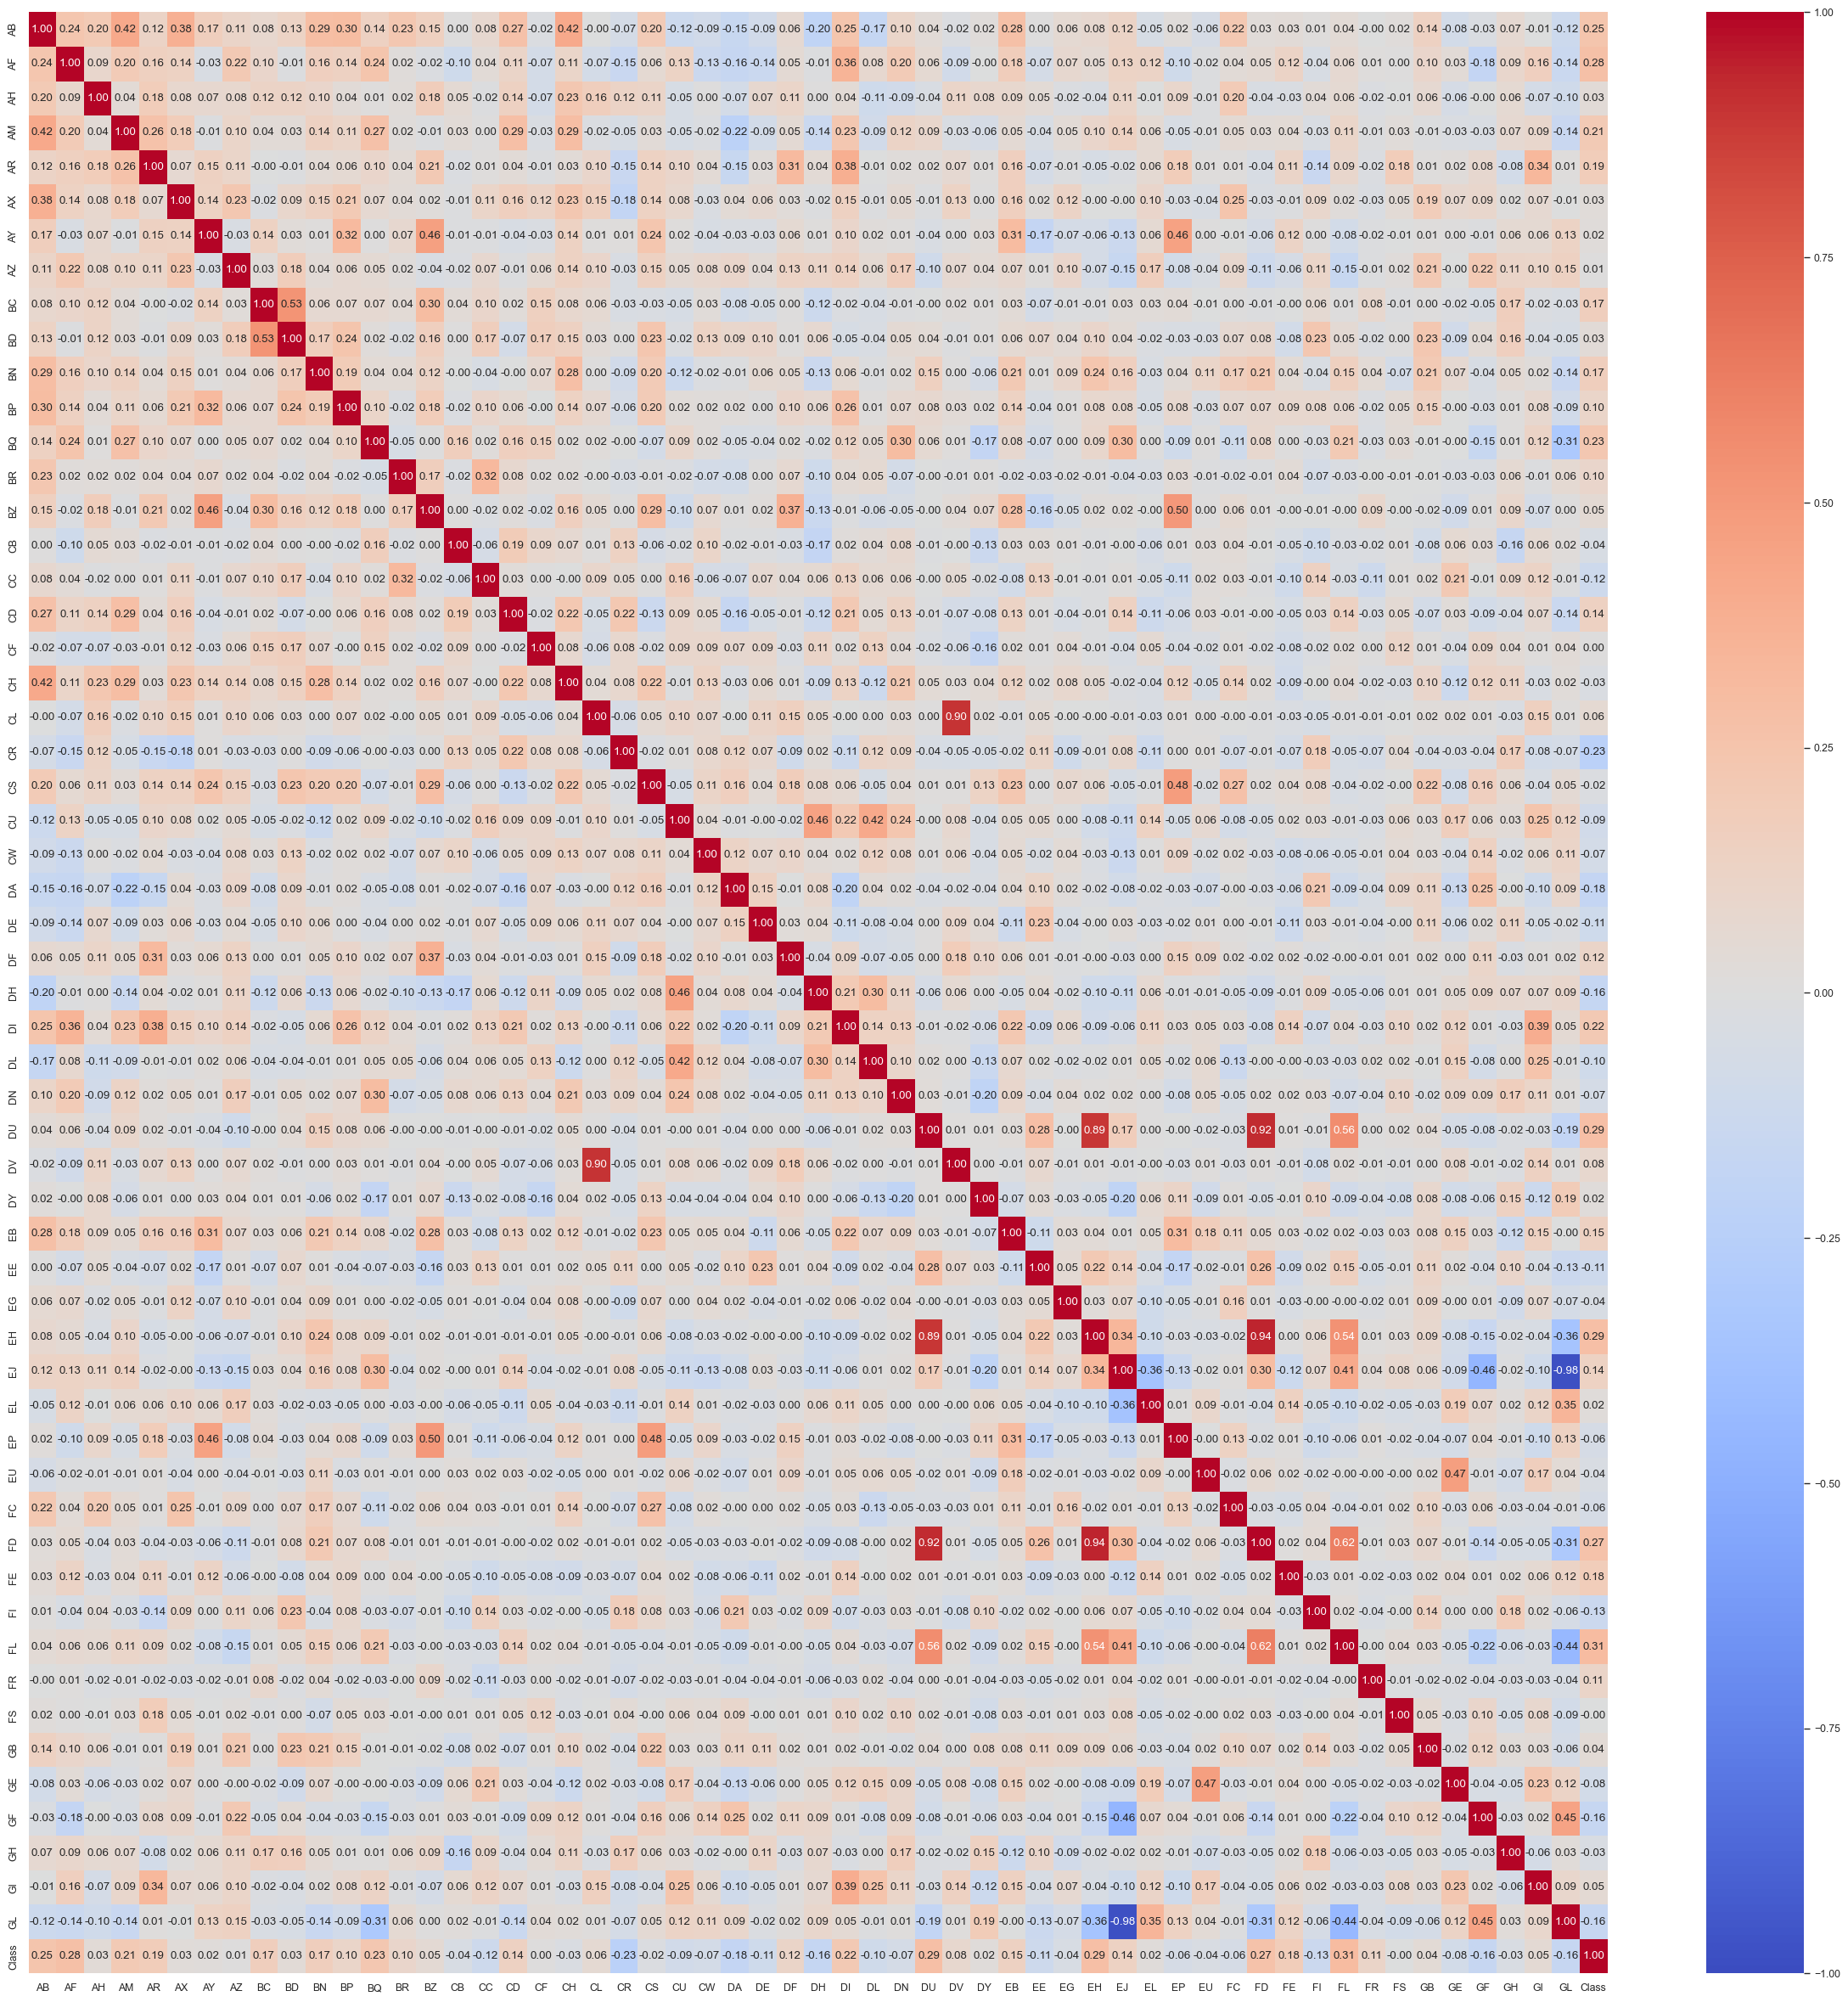

In [33]:
plt.figure(figsize=(30, 30))
sns.heatmap(outliers[outliers['outlier'] == 0].drop(columns='outlier').corr(), annot=True, fmt='.2f', cmap='coolwarm', vmin=-1, vmax=1);

In [34]:
outliers[outliers['outlier'] == 1].index

Int64Index([10, 51, 508, 384, 523, 230, 375, 581, 182, 353], dtype='int64')

In [35]:
# Remove outliers from train set
X_train = X_train.loc[outliers[outliers['outlier'] == 0].index]
y_train = y_train.loc[outliers[outliers['outlier'] == 0].index]

# Remove outliers from imputed train set
X_train_imp = X_train_imp.loc[outliers[outliers['outlier'] == 0].index]

### Normalize and Standardize

/Users/brunomotta/miniconda3/envs/kaggle/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (479). n_quantiles is set to n_samples.
  warnings.warn(


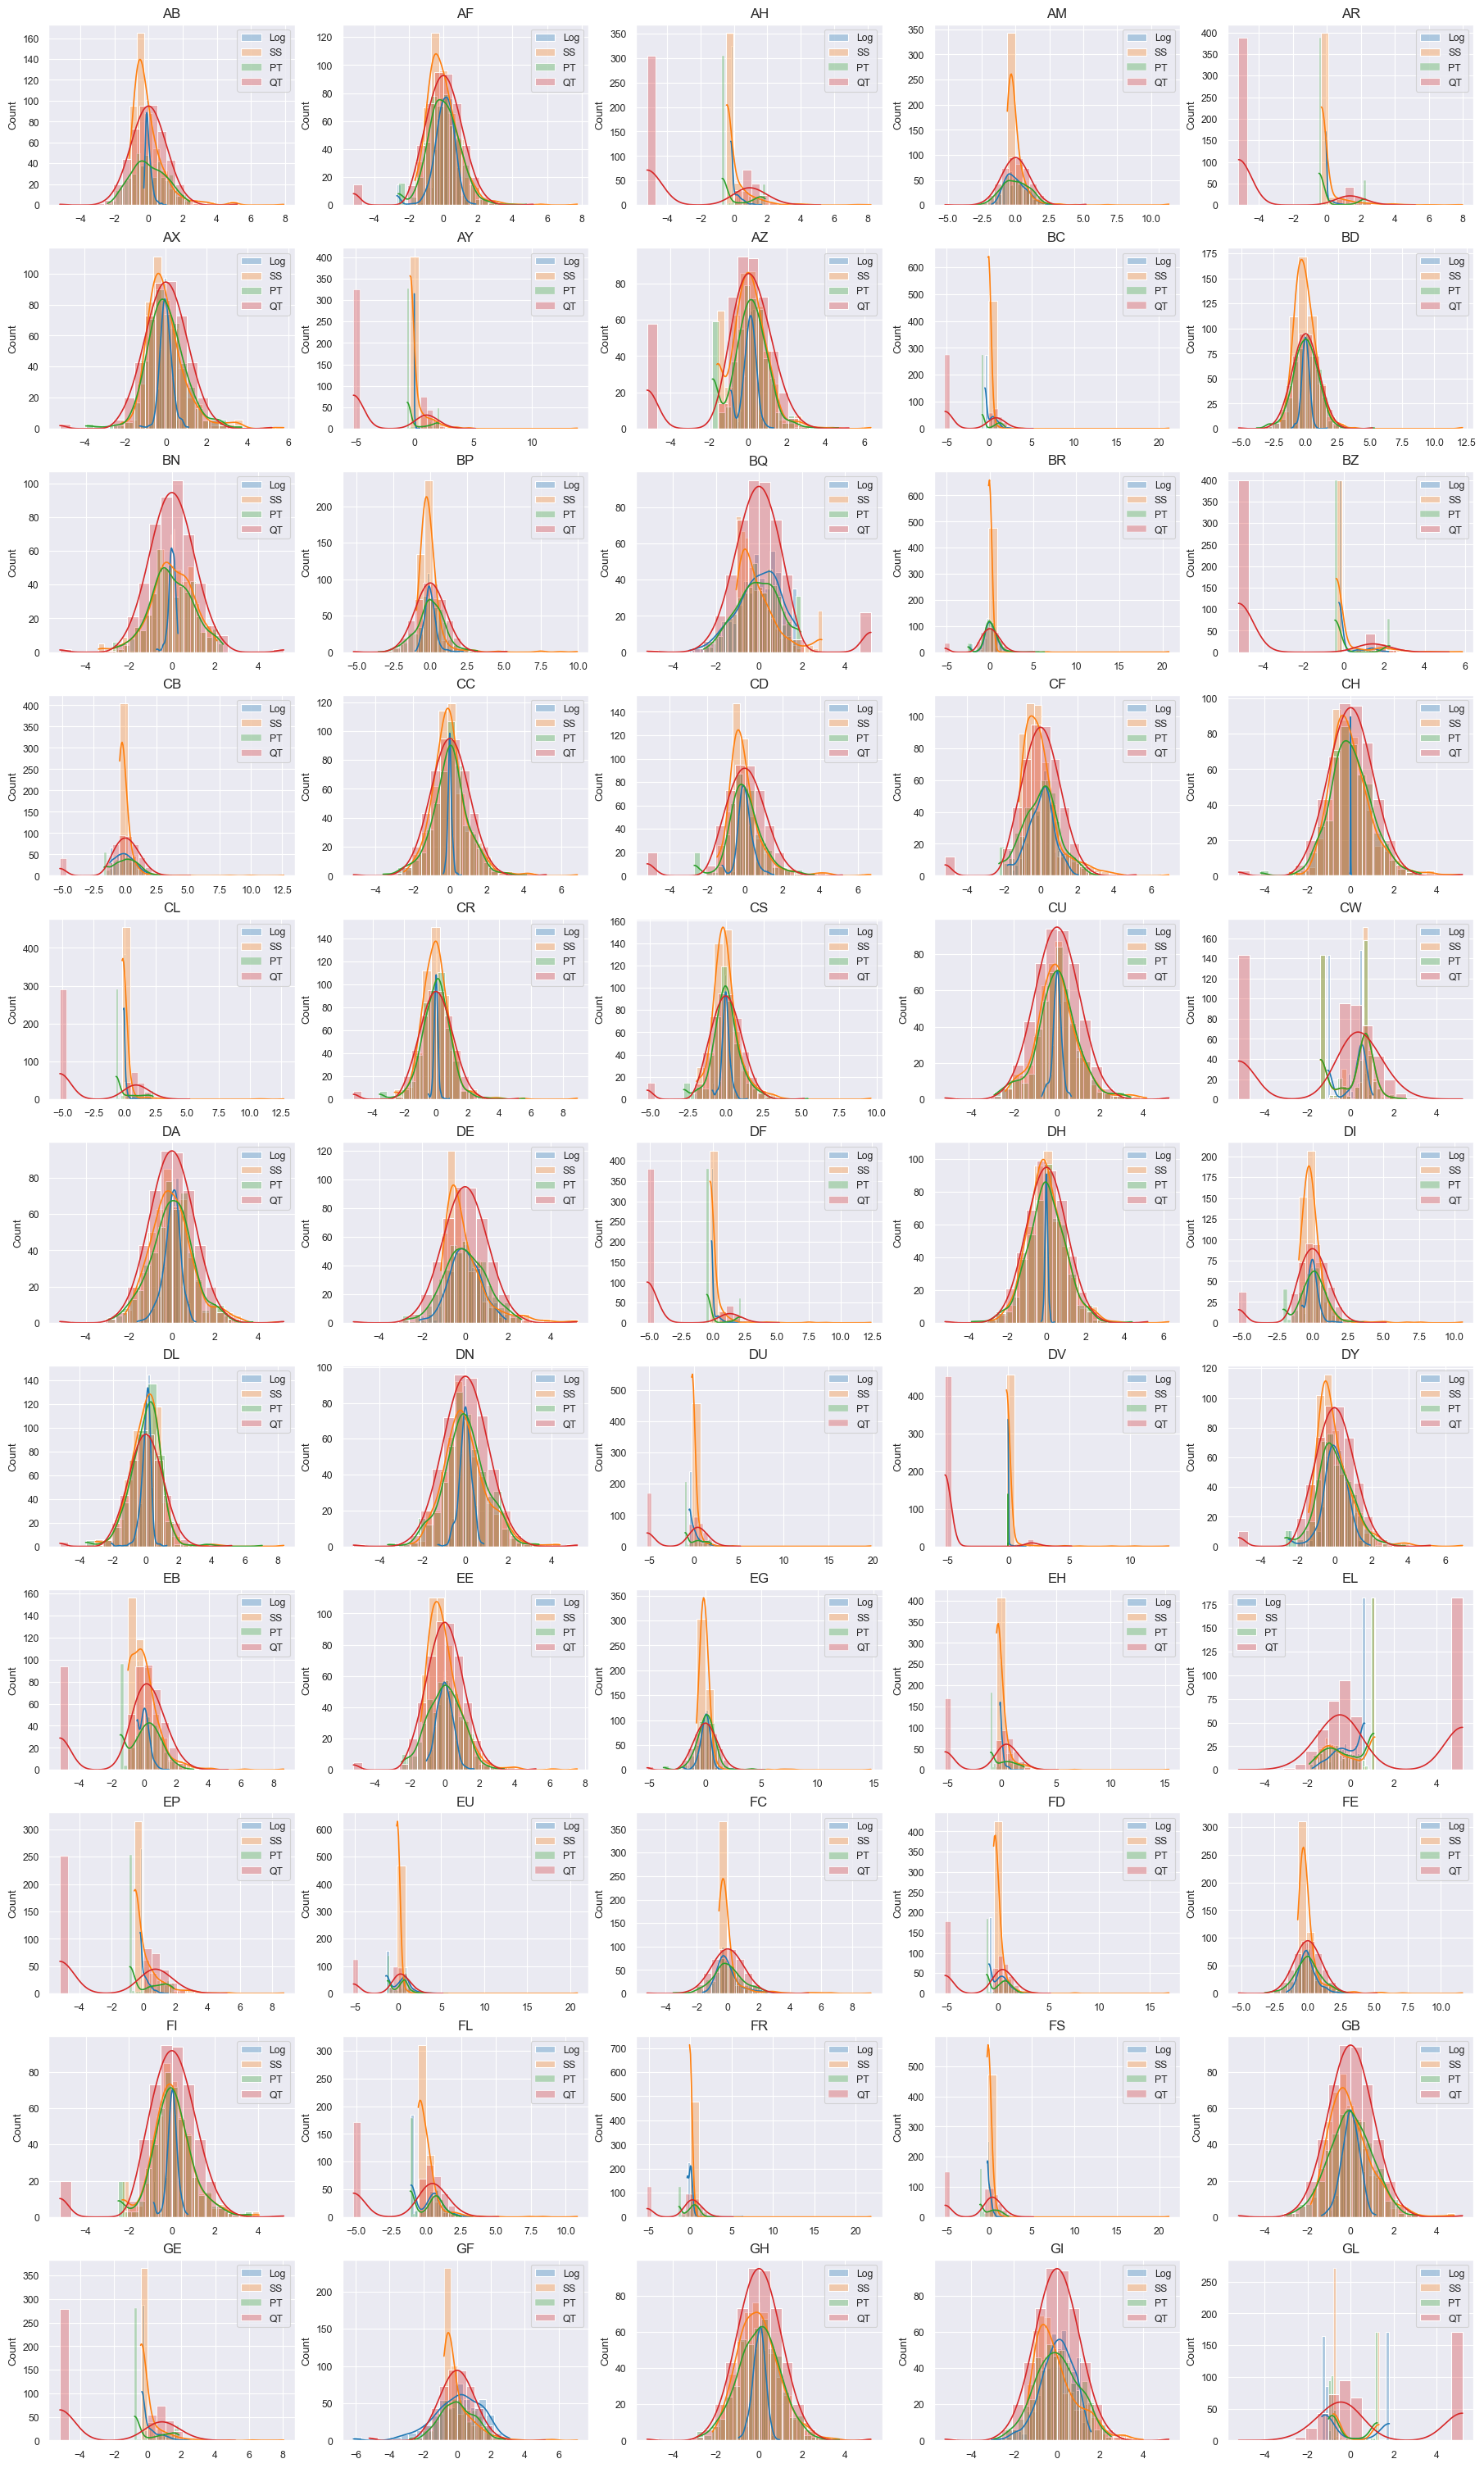

In [62]:
# Define transformer objects
ss = StandardScaler()
pt = PowerTransformer()
qt = QuantileTransformer(output_distribution='normal', random_state=random_state)

# Transform data
log_df = np.log1p(X_train_imp.drop(columns='EJ'))
log_mean = np.mean(log_df, axis=0)
log_df = log_df - log_mean
ss_df = pd.DataFrame(ss.fit_transform(X_train_imp.drop(columns='EJ')), columns=ss.feature_names_in_)
pt_df = pd.DataFrame(pt.fit_transform(X_train_imp.drop(columns='EJ')), columns=pt.feature_names_in_)
qt_df = pd.DataFrame(qt.fit_transform(X_train_imp.drop(columns='EJ')), columns=qt.feature_names_in_)

# Visualize distribution of features after transformation
fig, axs = plt.subplots(11, 5, figsize=(18, 30), layout='constrained')
sns.set_palette('tab10')

for i, col in enumerate(ss_df.columns, start=1):
    plt.subplot(11, 5, i)
    sns.histplot(x=log_df[col], bins=20, kde=True, alpha=0.3, label='Log')
    sns.histplot(x=ss_df[col], bins=20, kde=True, alpha=0.3, label='SS')
    sns.histplot(x=pt_df[col], bins=20, kde=True, alpha=0.3, label='PT')
    sns.histplot(x=qt_df[col], bins=20, kde=True, alpha=0.3, label='QT')
    plt.legend()
    plt.xlabel('')
    plt.title(col, fontsize=12)

In [63]:
print('Log Mean:', log_df.mean(axis=0).mean(), '+-', log_df.mean(axis=0).std(), '|', 'Log Std:', log_df.std(axis=0).mean(), '+-', log_df.std(axis=0).std())
print('SS Mean:', ss_df.mean(axis=0).mean(), '+-', ss_df.mean(axis=0).std(), '|', 'SS Std:', ss_df.std(axis=0).mean(), '+-', ss_df.std(axis=0).std())
print('PT Mean:', pt_df.mean(axis=0).mean(), '+-', pt_df.mean(axis=0).std(), '|', 'PT Std:', pt_df.std(axis=0).mean(), '+-', pt_df.std(axis=0).std())
print('QT Mean:', qt_df.mean(axis=0).mean(), '+-', qt_df.mean(axis=0).std(), '|', 'QT Std:', qt_df.std(axis=0).mean(), '+-', qt_df.std(axis=0).std())

Log Mean: -5.948089915001622e-17 +- 4.627901495949803e-16 | Log Std: 0.5096007575073206 +- 0.3332081800829483
SS Mean: 7.197801958852788e-18 +- 2.195711475869141e-16 | SS Std: 1.0010454785918597 +- 1.2733999435713963e-15
PT Mean: -8.63026569689101e-08 +- 5.903617518307204e-07 | PT Std: 0.9828446517083713 +- 0.13498094479721642
QT Mean: -0.7793360354341685 +- 1.3693746631637096 | QT Std: 1.7927698411265314 +- 0.8034866018863486


In [37]:
# PowerTransformer seem to perform best
pt = PowerTransformer()
X_train_scaled = pd.DataFrame(pt.fit_transform(X_train_imp.drop(columns='EJ')), columns=pt.feature_names_in_, index=X_train_imp.index)
X_train_scaled['EJ'] = X_train_imp['EJ']

# Transform validation set
X_val_scaled = pd.DataFrame(pt.transform(X_val_imp.drop(columns='EJ')), columns=pt.feature_names_in_, index=X_val_imp.index)
X_val_scaled['EJ'] = X_val['EJ']

### Principal Component Analysis (PCA)

/Users/brunomotta/miniconda3/envs/kaggle/lib/python3.10/site-packages/paretochart/paretochart.py:198: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels(yt)


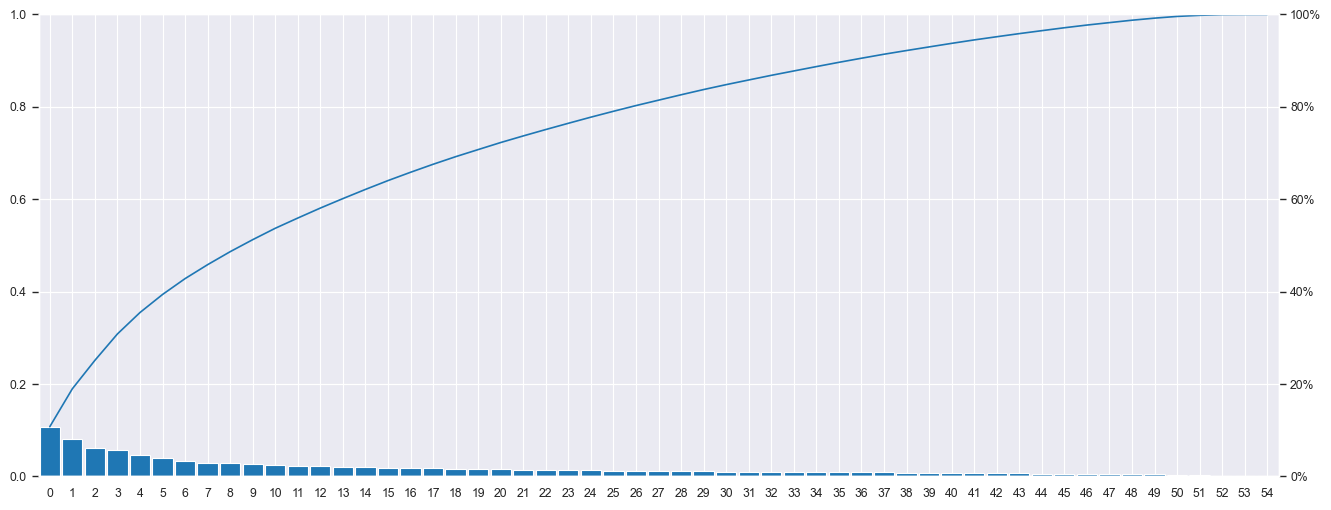

1 components: 10.78%
2 components: 18.98%
3 components: 25.13%
4 components: 30.85%
5 components: 35.49%
6 components: 39.39%
7 components: 42.82%
8 components: 45.84%
9 components: 48.66%
10 components: 51.26%
11 components: 53.72%
12 components: 55.94%
13 components: 58.1%
14 components: 60.15%
15 components: 62.13%
16 components: 64.04%
17 components: 65.84%
18 components: 67.57%
19 components: 69.22%
20 components: 70.75%
21 components: 72.28%
22 components: 73.71%
23 components: 75.1%
24 components: 76.45%
25 components: 77.77%
26 components: 79.04%
27 components: 80.28%
28 components: 81.45%
29 components: 82.62%
30 components: 83.75%
31 components: 84.81%
32 components: 85.82%
33 components: 86.82%
34 components: 87.77%
35 components: 88.72%
36 components: 89.64%
37 components: 90.53%
38 components: 91.39%
39 components: 92.19%
40 components: 92.97%
41 components: 93.75%
42 components: 94.49%
43 components: 95.18%
44 components: 95.85%
45 components: 96.49%
46 components: 97.13%

In [38]:
# Fit PCA
pca = PCA(n_components=len(X_train_scaled.columns), random_state=random_state)
pca.fit(X_train_scaled)

# Visualize explained variance ratio
fig, ax = plt.subplots(1, 1, figsize=(16, 6))
pareto(pca.explained_variance_ratio_)
plt.show()

# Calculate cumulative explained variance
explained_variances = (pca.explained_variance_ratio_.cumsum() * 100).round(2)
for c, i in enumerate(explained_variances, start=1):
    print(f'{c} components: {i}%')

In [39]:
def find_n_components(cumulative_variance, threshold = 80):
    for i, variance in enumerate(cumulative_variance):
        if variance >= threshold:
            return i + 1

In [40]:
# Transform data set with PCA
n_components = find_n_components(explained_variances, 80)
pca = PCA(n_components=n_components, random_state=random_state)

pca.fit(X_train_scaled)

X_train_pca = pca.transform(X_train_scaled)
X_val_pca = pca.transform(X_val_scaled)

# Create data frames
component_names = [f"PC{i+1}" for i in range(pca.components_.shape[0])]
X_train_pca = pd.DataFrame(X_train_pca, columns=component_names, index=X_train_scaled.index)
X_val_pca = pd.DataFrame(X_val_pca, columns=component_names, index=X_val_scaled.index)

In [41]:
X_train_pca

PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
96   2.408857  1.473371 -0.438248  0.636048 -1.774286 -0.419972  0.730787   
19  -4.197076 -2.453095 -0.400273  0.009431 -0.275043  1.447799 -2.021252   
32  -0.311748  0.525230 -4.473864  0.865027 -1.465576  0.237913 -0.015749   
576 -0.080492  1.199788 -0.001803  0.166415  1.027637 -0.592893  5.089988   
322 -1.178078  2.904470 -0.237332  1.833037  3.361865  0.540519 -2.257654   
..        ...       ...       ...       ...       ...       ...       ...   
38   0.031785 -3.432276 -3.937763  0.088667 -1.789952  0.101153  1.077779   
306 -1.917737  3.454364  1.167619 -0.741706 -0.741395 -0.080656 -1.473586   
287 -0.257550 -3.470048 -1.223114  0.345592  1.158532 -1.394924 -1.183032   
338  1.215666 -2.394836 -0.327921  0.466687  1.200863  1.330035 -0.473399   
409  3.283151  1.069819  0.585187  0.298354 -2.183517 -0.660306 -0.259664   

          PC8       PC9      PC10  ...      PC18      PC19      PC20  \
96  -0.005950  0.622183  1.173384  ... -0.008228 -0.512852 -0.497873   
19  -2.719613 -0.188416  1.583616  ... -1.157368  0.627306 -0.942502   
32   0.090178  2.434347  1.847770  ...  0.202130  1.891447 -0.495833   
576  1.833202 -3.434161  0.830248  ...  0.020764 -0.600782 -0.056259   
322 -1.051241  0.287382  0.951533  ...  0.678903 -1.283475 -1.308222   
..        ...       ...       ...  ...       ...       ...       ...   
38  -0.025756 -0.415583  0.398498  ... -0.760261 -0.390689 -0.131427   
306  2.362190 -2.624864 -0.884116  ... -1.709371 -0.000279  1.210530   
287  0.572193 -0.251992  0.260849  ...  0.484265 -0.793343  1.737970   
338  0.587483 -1.301935 -0.043981  ... -0.272994  1.211535  1.390632   
409  0.264861  1.274442 -1.498604  ...  0.512269 -0.211059  0.428411   

         PC21      PC22      PC23      PC24      PC25      PC26      PC27  
96   0.747334 -0.783136 -0.366072  0.283163  0.748214  1.028036 -0.833354  
19   0.056475 -1.541266  0.667655  0.148749 -0.195254  0.217851 -1.004859  
32  -0.790224  1.090386  0.382565 -0.674070 -1.305864 -1.565481  0.840438  
576  2.896401  1.788535  0.437050 -0.031374  0.340165  1.462672  1.064201  
322 -1.442629  0.995365  0.066876 -0.030389  1.620554  0.025252  1.032083  
..        ...       ...       ...       ...       ...       ...       ...  
38   1.885258 -0.126570 -0.127332 -0.477507  0.567509  0.833604  0.078460  
306 -0.066515  0.154546  0.395726  0.413073 -0.093642 -0.607783  0.111579  
287 -1.164488 -0.563476 -0.968334  0.469037 -0.205960 -0.626416  0.020962  
338 -1.045628  0.214394  1.601847  0.216711 -1.164173  0.059801 -1.401720  
409  1.947235  0.347798  1.096745 -2.199897 -0.205225 -0.700001  1.370303  

[479 rows x 27 columns]

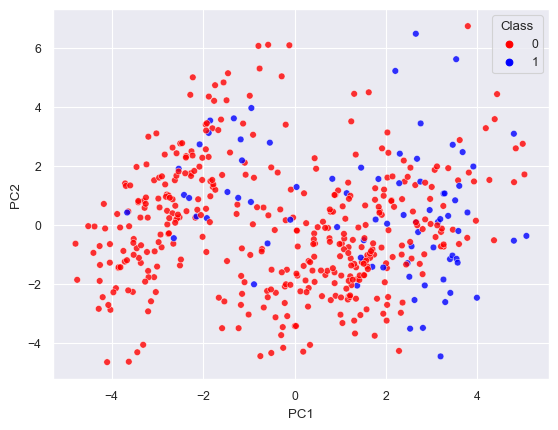

In [42]:
# Visualize components in 2D
sns.scatterplot(x='PC1', y='PC2', data=X_train_pca, hue=y_train, palette=['r', 'b'], alpha=0.8);